In [1]:
DATASET = 'OSCE/dor_toracica_x_infarto'
FILE = '../datasets/' + DATASET + '/respostas_ingles.txt'

with open(FILE) as f:
    data_samples = f.readlines()

In [2]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## SciKit LDA

Extracting tf-idf features for LDA...
done in 0.313s.
Extracting tf features for LDA...
done in 1.055s.


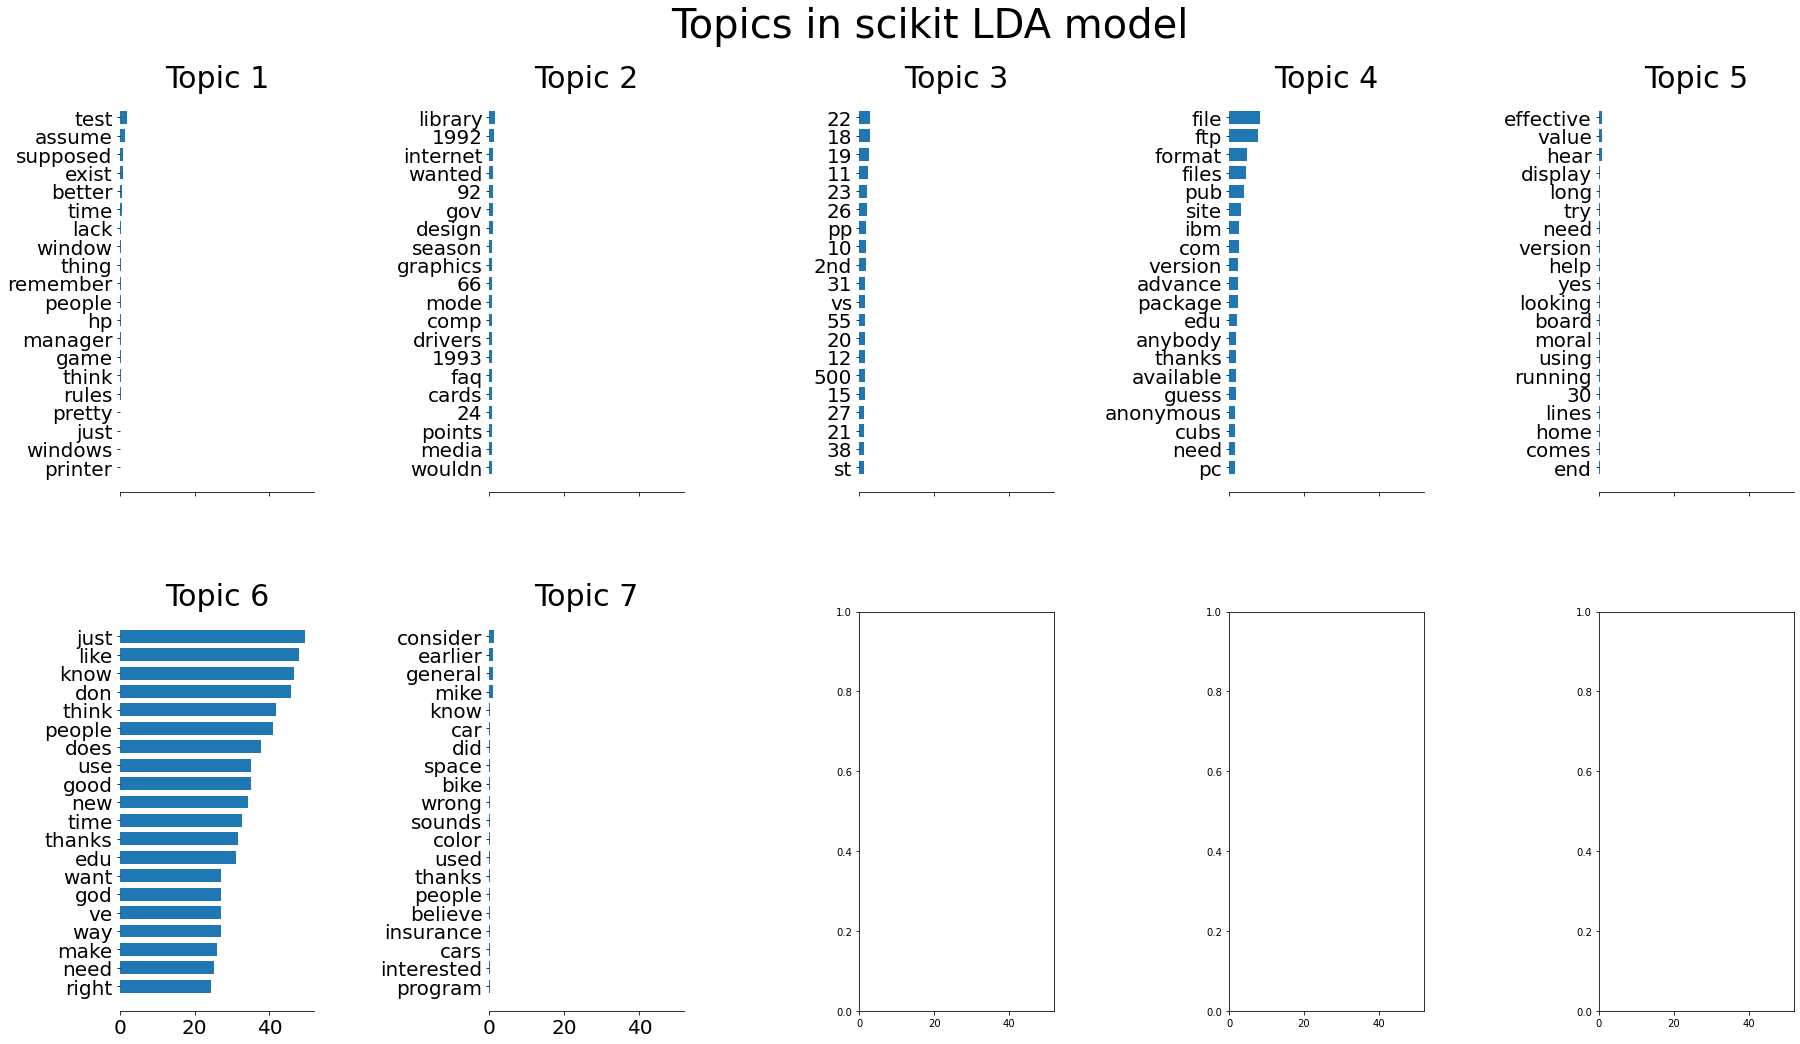

8.390083016424614e+233


In [17]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from time import time

n_samples = 2000
n_features = 1000
n_components = 7
n_top_words = 20

# DATASET = 'OSCE/dor_toracica_x_infarto'
# FILE = '../datasets/' + DATASET + '/respostas_ingles.txt'

# with open(FILE) as f:
#     data_samples = f.readlines()

#     print(data_samples)
    
# Use tf-idf features for NMF.
print("Extracting tf-idf features for LDA...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
# print(data_samples[0])

tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

tf = tf_vectorizer.fit_transform(data_samples)


lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()

aux_lda = lda.fit(tfidf)

print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in scikit LDA model")

print(aux_lda.perplexity(tfidf[0]))
# perplexity.append(news_lda.perplexity(doc_test))

## Gemsim LDA

In [4]:
from gensim.test.utils import common_corpus, common_dictionary, common_texts, simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# def preprocess(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

# print(data_samples[0])
data_samples2 = data_samples

# [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_samples2]

stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# # Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# data_samples2 = remove_stopwords(data_samples2)
# print(data_samples2)
# print(data_samples2)

# lista = []
# for sentence in data_samples2:
# #     print()
#     aqui = simple_preprocess(str(sentence), deacc=True)
# #     print(aqui)


# data_samples = preprocess(data_samples2)

# print('lista, :', lista)

for idx in range(len(data_samples2)):
#     print(data_samples2[idx])
    data_samples2[idx] = data_samples2[idx].lower()  # Convert to lowercase.
    data_samples2[idx] = tokenizer.tokenize(data_samples2[idx])  # Split into words.

# print(data_samples2[0])

# # Remove numbers, but not words that contain numbers.
data_samples2 = [[token for token in doc if not token.isnumeric()] for doc in data_samples2]
data_samples2 = [[token for token in doc if token not in stop_words] for doc in data_samples2]

# # Remove words that are only one character.
data_samples2 = [[token for token in doc if len(token) > 1] for doc in data_samples2]

# print(data_samples2)


dictionary = Dictionary(data_samples2)
corpus = [dictionary.doc2bow(text) for text in data_samples2]
texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]

# print(dictionary)
# print(corpus)
# print(data_samples2[0])



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
print(dictionary)
model = LdaModel(corpus, 100, dictionary)

cm = CoherenceModel(model=model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')

coherence = cm.get_coherence()  # get coherence value
print('coherence:',coherence)

# print(model.print_topics())
doc_lda = model[corpus]
# print(str(doc_lda))
print('Coerência por Tópico: ',cm.get_coherence_per_topic())


Dictionary(941 unique tokens: ['acute', 'addition', 'ami', 'anginal', 'area']...)
coherence: 0.6725165943788666
Coerência por Tópico:  [0.5204592507299095, 0.7035726271034438, 0.48112199742626344, 0.8025610285106705, 0.7818095917202749, 0.615283914663393, 0.8025610285106705, 0.47150052524091074, 0.7512762458785383, 0.6284987196972908, 0.8025610285106705, 0.7680516443953336, 0.7621227622435086, 0.762943710719601, 0.6520808184831264, 0.6851823194021318, 0.6557021684699484, 0.28765240566990213, 0.8018019677071312, 0.7823296928468979, 0.8025610285106705, 0.6201751987926866, 0.4294269871681455, 0.36712689633537987, 0.5955742092987824, 0.283192870226114, 0.5280919956099699, 0.5962322447073745, 0.832275712730351, 0.8025610285106705, 0.3530138317833712, 0.5366978370022156, 0.8712847937775333, 0.8025610285106705, 0.7708082011578772, 0.7100257739543361, 0.8721945136642091, 0.8668246904176984, 0.8025610285106705, 0.4905479990775724, 0.4053310677887413, 0.3431508836375229, 0.6227341375569785, 0.52

# ---------------------
## Exemplo tutorial

Loading dataset...
done in 1.590s.
Extracting tf-idf features for NMF...
done in 0.311s.
Extracting tf features for LDA...


 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 3.104s.


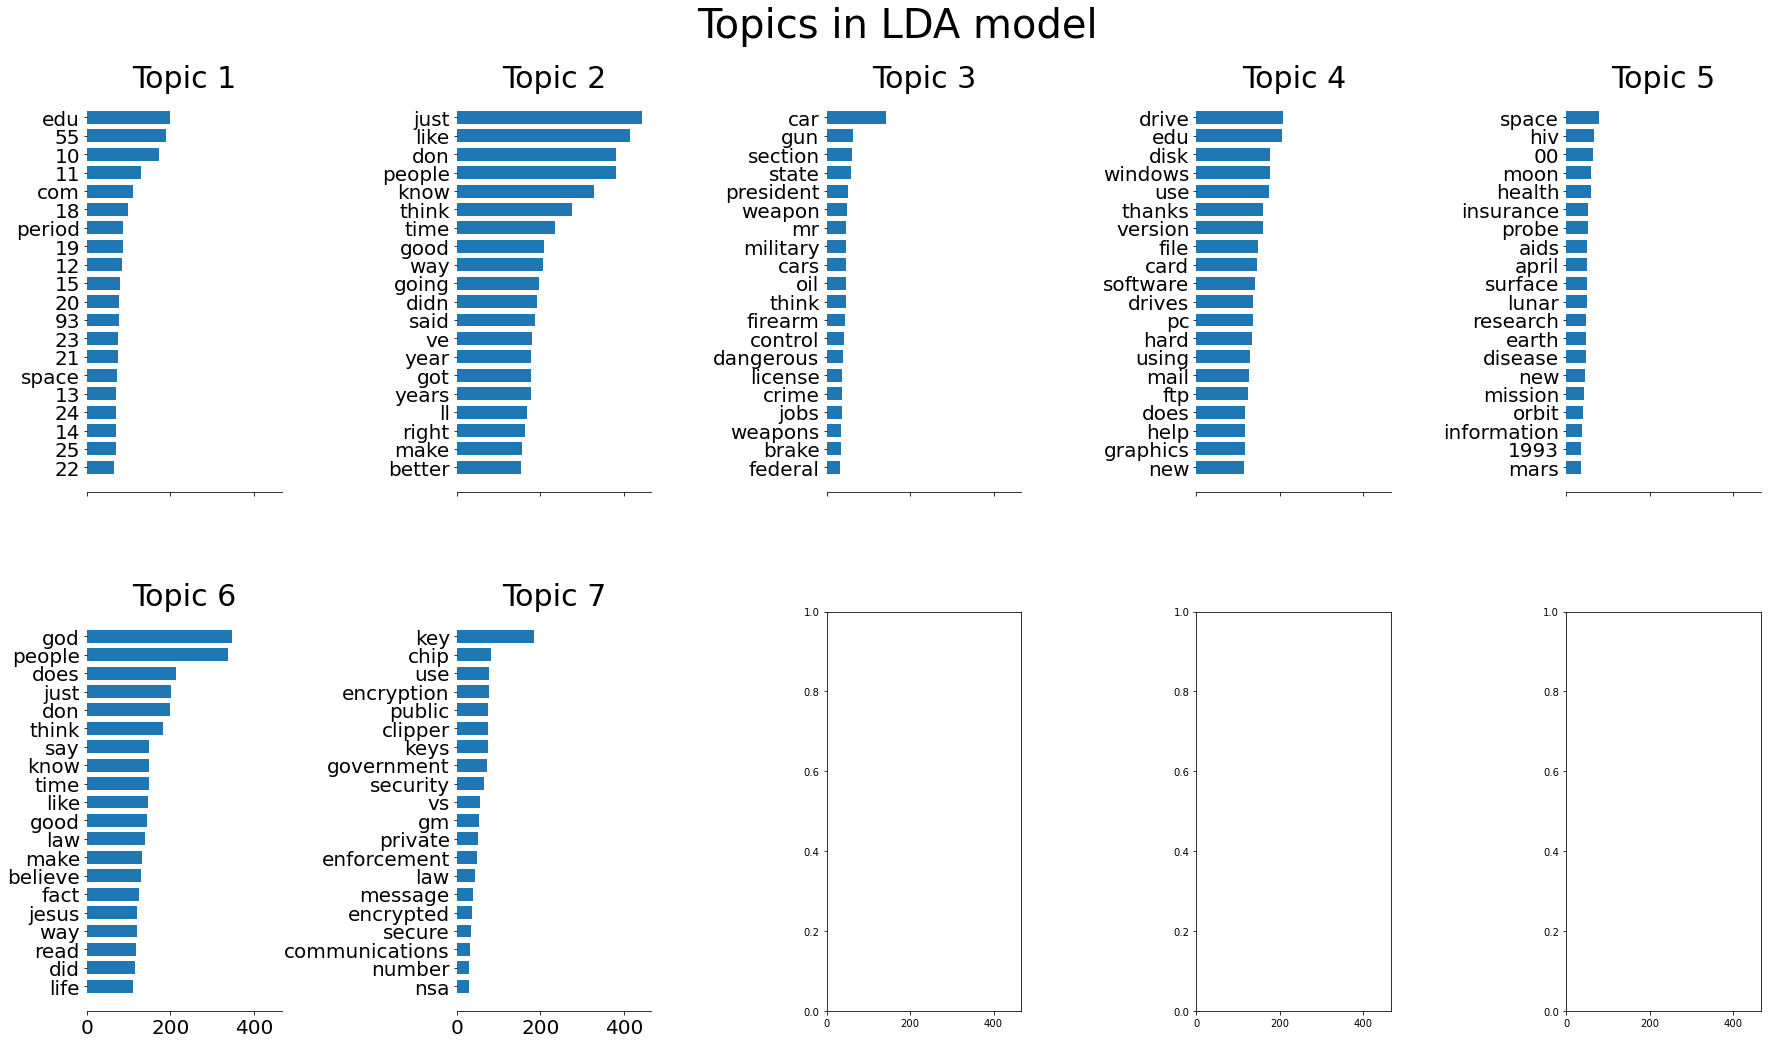

In [6]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 7
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
#     print(model.components_)
    for topic_idx, topic in enumerate(model.components_):
#         print(topic)
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
#         print(top_features_ind)
        top_features = [feature_names[i] for i in top_features_ind]
#         print(top_features)
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, y = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
# print(type(tfidf))
# print(tfidf.shape)
# print(len(tfidf[0]))

# print(tfidf.toarray())

print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

tf = tf_vectorizer.fit_transform(data_samples)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# ----------------

In [7]:
from sklearn.datasets import make_multilabel_classification

# This produces a feature matrix of token counts, similar to what CountVectorizer would produce on text.
X, Y = make_multilabel_classification(random_state=0)

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# get topics for some given samples:
print(lda.transform(X[-2:]))
print('Perplexity ', lda.perplexity(X))

[[0.00360392 0.25499205 0.0036211  0.64236448 0.09541846]
 [0.15297572 0.00362644 0.44412786 0.39568399 0.003586  ]]
Perplexity  21.089949665885218


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()

texts = ['eu voce que tal', 'ola meu bem', 'bora?']
fitted = vec.fit_transform(texts)
fitted.toarray()

array([[0, 0, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]])

In [9]:
vec.get_feature_names_out()

array(['bem', 'bora', 'eu', 'meu', 'ola', 'que', 'tal', 'voce'],
      dtype=object)

In [10]:
from gensim.test.utils import common_corpus, common_dictionary

from gensim.models.coherencemodel import CoherenceModel

topics = [

    ['human', 'computer', 'system', 'interface'],

    ['graph', 'minors', 'trees', 'eps']

]

cm = CoherenceModel(topics=topics, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')

coherence = cm.get_coherence()  # get coherence value
print(coherence)
print(cm.get_coherence_per_topic())

-7.105015580153772
[-0.7607246985689725, -13.449306461738571]


In [11]:
from gensim.corpora import Dictionary

texts2 = [['eu voce que tal', 'ola meu bem', 'bora?']]


dct = Dictionary(texts2)
bow = dct.doc2bow(["eu voce que tal", "ola meu bem"])
# bow = dct.doc2bow([])

In [12]:
dct2 = Dictionary(["máma mele maso".split(), "ema má máma".split()])
str(dct2)

"Dictionary(5 unique tokens: ['maso', 'mele', 'máma', 'ema', 'má'])"

# -----------------

In [13]:
# from gensim.models import CoherenceModel, LdaModel, HdpModel
# from gensim.corpora import Dictionary

# # texts = [['human', 'interface', 'computer'],
# #          ['survey', 'user', 'computer', 'system', 'response', 'time'],
# #          ['eps', 'user', 'interface', 'system'],
# #          ['system', 'human', 'system', 'eps'],
# #          ['user', 'response', 'time'],
# #          ['trees'],
# #          ['graph', 'trees'],
# #          ['graph', 'minors', 'trees'],
# #          ['graph', 'minors', 'survey']]
# # texts = [['human', 'interface', 'computer'], ['coronary', 'ecg']]
# texts = data_samples
# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# print(corpus)
# print(dictionary)

In [14]:
# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# import numpy as np
# # lda_model - LatentDirichletAllocation()
# # vect - CountVectorizer()
# # texts - the list of tokenized words
# metric_coherence_gensim(measure='c_v', 
#                         top_n=25, 
#                         topic_word_distrib=lda.components_, 
# #                         dtm=dtm_tf, 
#                         gensim_corpus  = corpus,                     
#                         vocab=np.array([x for x in vect.vocabulary_.keys()]), 
#                         texts=train['cleaned_NOUN'].values)